## 1. Get the dataset

In [73]:
pip install geopy

     |████████████████████████████████| 111 kB 3.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [97]:
import numpy as np 
import pandas as pd
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [57]:
# load the wiki page into a data frame
df=pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]
df

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


In [58]:
# drop the cell with a borough that is "not assigned" and reset the index
df = df[(df.Borough != 'Not assigned')].reset_index()
df

,index,Postal Code,Borough,Neighbourhood
0,2,M3A,North York,Parkwoods
1,3,M4A,North York,Victoria Village
2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,5,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...,...
98,160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,165,M4Y,Downtown Toronto,Church and Wellesley
100,168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [59]:
# drop the 'index' column
df_new = df.drop(columns=['index'])
df_new

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [60]:
# these 2 cells below used to check if my data frame meets all the requirements
df_new.loc[df_new['Postal Code']=='M5A']

,Postal Code,Borough,Neighbourhood
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [61]:
df_new.loc[df_new['Neighbourhood']=='Not assigned']

,Postal Code,Borough,Neighbourhood


In [62]:
# print the shape as per instruction
df_new.shape

(103, 3)

In [64]:
# read the coordinates file into a dataframe
df_coor = pd.read_csv('file:///Users/meihao/Desktop/Geospatial_Coordinates.csv')
df_coor

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [70]:
# merge two dataframes in order to get the coordicates for each neighbourhood
df_merged = pd.merge(df_coor,df_new, on='Postal Code')
df_merged

,Postal Code,Latitude,Longitude,Borough,Neighbourhood
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae
...,...,...,...,...,...
98,M9N,43.706876,-79.518188,York,Weston
99,M9P,43.696319,-79.532242,Etobicoke,Westmount
100,M9R,43.688905,-79.554724,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,43.739416,-79.588437,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [84]:
# get the toronto data by filtering out the original dataframe
df_toronto = df_merged[df_merged['Borough'].str.contains("Toronto")].reset_index().drop(columns=['index'])
df_toronto

,Postal Code,Latitude,Longitude,Borough,Neighbourhood
0,M4E,43.676357,-79.293031,East Toronto,The Beaches
1,M4K,43.679557,-79.352188,East Toronto,"The Danforth West, Riverdale"
2,M4L,43.668999,-79.315572,East Toronto,"India Bazaar, The Beaches West"
3,M4M,43.659526,-79.340923,East Toronto,Studio District
4,M4N,43.728020,-79.388790,Central Toronto,Lawrence Park
5,M4P,43.712751,-79.390197,Central Toronto,Davisville North
6,M4R,43.715383,-79.405678,Central Toronto,"North Toronto West, Lawrence Park"
7,M4S,43.704324,-79.388790,Central Toronto,Davisville
8,M4T,43.689574,-79.383160,Central Toronto,"Moore Park, Summerhill East"
9,M4V,43.686412,-79.400049,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest..."


In [85]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [86]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [87]:
# define foursquare credentials and version
CLIENT_ID = 'QXTBRXWJZUSO1CRSN2NIOWXYGVKHD525K4JW1QLTL21U1NJV' # your Foursquare ID
CLIENT_SECRET = 'ZANTWDSZECLHVCG2QPFHKZ3OSKEGTGCDJ453NQJRGZTVWDRX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QXTBRXWJZUSO1CRSN2NIOWXYGVKHD525K4JW1QLTL21U1NJV
CLIENT_SECRET:ZANTWDSZECLHVCG2QPFHKZ3OSKEGTGCDJ453NQJRGZTVWDRX


### Let's explore the first neighbourhood in our dataframe

In [88]:
df_toronto.loc[0, 'Neighbourhood']

'The Beaches'

In [90]:
#Get the neighborhood's latitude and longitude values.
neighborhood_latitude = df_toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_toronto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_toronto.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


#### Now, let's get the top 100 venues that are in The Beaches within a radius of 500 meters.

In [127]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
CLIENT_ID,
CLIENT_SECRET,
neighborhood_latitude, 
neighborhood_longitude, 
VERSION,
radius,
LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?client_id=QXTBRXWJZUSO1CRSN2NIOWXYGVKHD525K4JW1QLTL21U1NJV&client_secret=ZANTWDSZECLHVCG2QPFHKZ3OSKEGTGCDJ453NQJRGZTVWDRX&ll=43.67635739999999,-79.2930312&v=20180605&radius=500&limit=100'

Send the GET request and examine the resutls

In [128]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f90c1e2524ab44c02f47c62'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'The Beaches',
  'headerFullLocation': 'The Beaches, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.680857404499996,
    'lng': -79.28682091449052},
   'sw': {'lat': 43.67185739549999, 'lng': -79.29924148550948}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd461bc77b29c74a07d9282',
       'name': 'Glen Manor Ravine',
       'location': {'address': 'Glen Manor',
        'crossStreet': 'Queen St.',
        'lat': 43.67682094413784,
        'lng': -79.29394208780985,
        'labeledLatLngs': [{'labe

In [129]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.

In [130]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-130-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Upper Beaches,Neighborhood,43.680563,-79.292869


Lets find out how many venues are within 500 meters radius of The Beaches

In [133]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


## 2. Explore Neighborhoods in Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [134]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        # this line used to get all the venue info
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        # each neighborhood may contain several different venues
        venues_list.append([(
            name, # neighborhood name
            lat,  # neighborhood lat
            lng,  # neighborhood lng
            v['venue']['name'],  # venue name
            v['venue']['location']['lat'],  # venue lat
            v['venue']['location']['lng'],  # venue lng
            v['venue']['categories'][0]['name']) for v in results]) # venue category

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [135]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

In [141]:
print(toronto_venues.shape)
toronto_venues.head()

(1624, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


#### Let's check how many venues were returned for each neighborhood


In [142]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


#### Let's find out how many unique categories can be curated from all the returned venues

In [143]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 uniques categories.


## 3. Analyze Each Neighborhood

In [206]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = list(toronto_onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
toronto_onehot = toronto_onehot.loc[:,cols]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [207]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.018182,0.036364,0.000000,0.000000,0.00,0.018182,0.018182,0.000000,0.036364,0.000000,0.000000,0.018182,0.0000,0.000000,0.0000,0.00,0.018182,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.018182,0.00,0.000000,0.0000,0.000000,0.036364,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.090909,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.018182,0.000000,0.018182,0.000000,0.000000,0.000000,0.018182,0.00

#### Let's print each neighborhood along with the top 5 most common venues

In [208]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.04
2        Beer Bar  0.04
3  Farmers Market  0.04
4     Cheese Shop  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3       Nightclub  0.09
4       Pet Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Gym / Fitness Center  0.06
1         Auto Workshop  0.06
2           Pizza Place  0.06
3            Comic Shop  0.06
4      Recording Studio  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0      Airport Lounge  0.12
1     Airport Service  0.12
2               Plane  0.06
3    Sculpture Garden  0.06
4  Airport Food Court  0.06


----Central Bay Street----
                venue  freq
0         Coffee Sho

#### Let's put that into a _pandas_ dataframe

In [209]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [210]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues): # np.arange returns evenly spaced values within a given interval.
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Farmers Market,Beer Bar,Restaurant,Cheese Shop,Bistro,Concert Hall
1,"Brockton, Parkdale Village, Exhibition Place",Café,Nightclub,Coffee Shop,Breakfast Spot,Bakery,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant
2,"Business reply mail Processing Centre, South C...",Pizza Place,Garden Center,Farmers Market,Butcher,Brewery,Burrito Place,Recording Studio,Garden,Auto Workshop,Fast Food Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Boutique,Plane,Airport,Airport Food Court,Airport Gate,Airport Terminal,Bar,Harbor / Marina
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Bubble Tea Shop,Department Store,Burger Joint,Japanese Restaurant,Thai Restaurant


## 4. Cluster Neighborhoods

### Before we dive into Kmeans itself, let's first tune our K value a little bit 

In [211]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


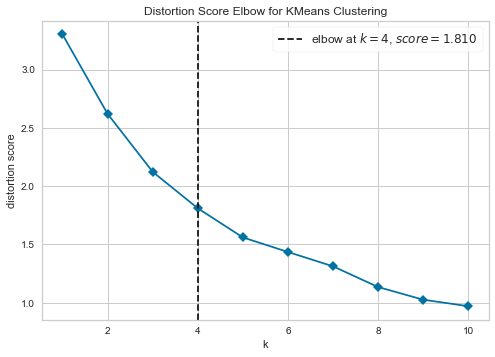

In [212]:
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,11), timings=False)
visualizer.fit(toronto_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Run _k_-means to cluster the neighborhood into 5 clusters.

In [213]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

#### rename the column "Neighbourhood" into "Neighborhood" for merging purpose later on 

In [214]:
df_toronto = df_toronto.rename(columns={'Neighbourhood':'Neighborhood'})
df_toronto.head()

,Postal Code,Latitude,Longitude,Borough,Neighborhood
0,M4E,43.676357,-79.293031,East Toronto,The Beaches
1,M4K,43.679557,-79.352188,East Toronto,"The Danforth West, Riverdale"
2,M4L,43.668999,-79.315572,East Toronto,"India Bazaar, The Beaches West"
3,M4M,43.659526,-79.340923,East Toronto,Studio District
4,M4N,43.728020,-79.388790,Central Toronto,Lawrence Park


In [215]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with df_toronto to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Latitude,Longitude,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,43.676357,-79.293031,East Toronto,The Beaches,0,Health Food Store,Pub,Trail,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Donut Shop
1,M4K,43.679557,-79.352188,East Toronto,"The Danforth West, Riverdale",2,Greek Restaurant,Coffee Shop,Italian Restaurant,Bookstore,Restaurant,Ice Cream Shop,Furniture / Home Store,Pub,Spa,Indian Restaurant
2,M4L,43.668999,-79.315572,East Toronto,"India Bazaar, The Beaches West",2,Park,Gym,Pub,Sandwich Place,Liquor Store,Burrito Place,Italian Restaurant,Restaurant,Fast Food Restaurant,Fish & Chips Shop
3,M4M,43.659526,-79.340923,East Toronto,Studio District,2,Coffee Shop,Bakery,Gastropub,Brewery,Café,American Restaurant,Convenience Store,Bookstore,Seafood Restaurant,Cheese Shop
4,M4N,43.728020,-79.388790,Central Toronto,Lawrence Park,1,Park,Bus Line,Swim School,Dim Sum Restaurant,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [216]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

#### Cluster 1: Outdoor enthusiast

In [217]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,43.676357,0,Health Food Store,Pub,Trail,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Donut Shop
8,43.689574,0,Playground,Trail,Yoga Studio,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


#### Cluter 2 : Parker

In [218]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,43.728020,1,Park,Bus Line,Swim School,Dim Sum Restaurant,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
10,43.679563,1,Park,Playground,Trail,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
23,43.696948,1,Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


#### Cluter 3 : Food Lover

In [220]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,43.679557,2,Greek Restaurant,Coffee Shop,Italian Restaurant,Bookstore,Restaurant,Ice Cream Shop,Furniture / Home Store,Pub,Spa,Indian Restaurant
2,43.668999,2,Park,Gym,Pub,Sandwich Place,Liquor Store,Burrito Place,Italian Restaurant,Restaurant,Fast Food Restaurant,Fish & Chips Shop
3,43.659526,2,Coffee Shop,Bakery,Gastropub,Brewery,Café,American Restaurant,Convenience Store,Bookstore,Seafood Restaurant,Cheese Shop
5,43.712751,2,Department Store,Dog Run,Park,Gym / Fitness Center,Breakfast Spot,Dance Studio,Hotel,Sandwich Place,Food & Drink Shop,Discount Store
6,43.715383,2,Coffee Shop,Clothing Store,Yoga Studio,Chinese Restaurant,Salon / Barbershop,Fast Food Restaurant,Spa,Diner,Sporting Goods Shop,Restaurant
7,43.704324,2,Dessert Shop,Sandwich Place,Pizza Place,Gym,Italian Restaurant,Coffee Shop,Café,Sushi Restaurant,Pharmacy,Seafood Restaurant
9,43.686412,2,Coffee Shop,Pizza Place,Light Rail Station,Liquor Store,Restaurant,Bank,Bagel Shop,Pub,Supermarket,Fried Chicken Joint
11,43.667967,2,Coffee Shop,Café,Pizza Place,Restaurant,Italian Restaurant,Market,Park,Chinese Restaurant,Bakery,Pub
12,43.665860,2,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Yoga Studio
13,43.654260,2,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant


#### Cluter 4 : Musician

In [222]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,43.711695,3,Music Venue,Garden,Yoga Studio,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
